# Machine learning with RDkit - Predict solubility 

Now that we know how to handle molecule data we will try to do a first machine learning pipeline to predict solubility

In this exercise, we will use machine learning to predict solubility of molecules. For this purpose, we will borrow a dataset from rdkit that is originated from the Huuskonen dataset. We will try to predict Aqueous Solubility for molecules that is known as "logS". 


This exercise is divided into 3 parts: Preparing a dataset, training a model and preparing dataset for prediction and applying a predictive model.



## Preparing dataset




Download the training set from "https://raw.githubusercontent.com/rdkit/rdkit/master/Docs/Book/data/solubility.train.sdf".



In [1]:
!mkdir data && cd data && wget https://raw.githubusercontent.com/rdkit/rdkit/master/Docs/Book/data/solubility.train.sdf

mkdir: cannot create directory ‘data’: File exists



With the help of rdkit.Chem.SDMolSupplier, get list of molecules contained in this file. You should call this list as **molecule_list**. The option **removeHs=False** should be chosen. 



In [2]:
import rdkit
from rdkit.Chem import SDMolSupplier

molecule_list = SDMolSupplier("data/solubility.train.sdf", removeHs=False)

print(f"We have {len(molecule_list)} molecules.")
print(type(molecule_list[0]))

We have 1025 molecules.
<class 'rdkit.Chem.rdchem.Mol'>



Write a function named **calculate_descriptors(mol)** that allows us to calculate descriptors of a molecule. This function takes a Rdkit molecule as input and returns an array vector of descriptors.



In [3]:
from typing import Dict
import numpy as np

from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator

def calculate_descriptors(mol: rdkit.Chem.rdchem.Mol) -> Dict[str, float]:
    descriptor_names = [ desc[0] for desc in Descriptors._descList]

    calculator = MolecularDescriptorCalculator(descriptor_names)
    mol_descriptors = calculator.CalcDescriptors(mol)
    
    return {descriptor_names[i]: mol_descriptors[i] for i in range(len(descriptor_names))}
    


Apply the function **caluclate_descriptors** to the list of molecules **molecule_list** and store the result in a dataframe named **df**. Look at few rows of **df** to see whether the descriptors are calculated.

Get alslow the sollubity with the GetProp method



In [4]:
import pandas as pd
df = pd.DataFrame([calculate_descriptors(mol) for mol in molecule_list])

df.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,2.211806,1.343750,2.211806,1.343750,0.468786,72.151,60.055,72.09390,32,0,...,0,0,0,0,0,0,0,0,0,0
1,1.500000,1.500000,1.500000,1.500000,0.408362,70.135,60.055,70.07825,30,0,...,0,0,0,0,0,0,0,0,0,0
2,2.231806,1.355000,2.231806,1.355000,0.462954,86.178,72.066,86.10955,38,0,...,0,0,0,0,0,0,0,0,1,0
3,2.253472,0.898148,2.253472,0.898148,0.483890,86.178,72.066,86.10955,38,0,...,0,0,0,0,0,0,0,0,0,0
4,2.243056,0.541667,2.243056,0.541667,0.424482,86.178,72.066,86.10955,38,0,...,0,0,0,0,0,0,0,0,0,0


For each molecule from this dataset, we can get the aqueous solubility (logS) via attribute **getProp('SOL')**. Create a list that contains the aqueous solubility of all molecules from the **molecule_list** list. You should call this list by **labels**. Remember to convert these values to float format.




In [5]:
labels = [float(mol.GetProp("SOL")) for mol in molecule_list]

Plot the histogram of the "labels" list to see the distribution of the solubility of molecules. Do you have some comments about the aqueous solubility of molecules ?



(array([  2.,   3.,  20.,  32.,  62., 166., 236., 289., 159.,  56.]),
 array([-11.62, -10.3 ,  -8.98,  -7.66,  -6.34,  -5.02,  -3.7 ,  -2.38,
         -1.06,   0.26,   1.58]),
 <BarContainer object of 10 artists>)

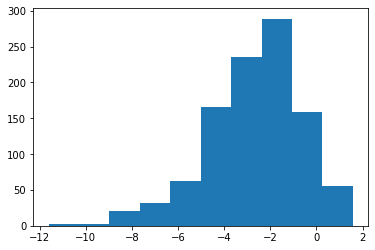

In [6]:
import matplotlib.pyplot as plt

plt.hist(labels)

**Student answer**:

our molecules solubility seems to follow a normal law with a mean value of -3 and a std of 2.

### Feature Engineering 

Now, we have the **df** dataframe that contains the descriptors for molecules and the **labels** list that contains the solvant property of molecules.

Check the dataframe **df** to see whether it contains NaN values. How many row contained NaN values are there in the dataframe **df** ? Remove these rows from  **df** and **labels**.



In [7]:
na_list = df.isna().any(1)[df.isna().any(1) == True]
labels = np.delete(np.array(labels), na_list.index)
df.dropna(inplace=True)


Apply the MinMaxScaler to the dataframe **df** to normalize the data.



In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(df)
df = scaler.transform(df)

Instanciate a linear regression and train it to predict the solubility from the features

In [9]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression().fit(df, labels)


Calculate the square root error for the dataset

In [10]:
from sklearn.metrics import mean_squared_error

predictions = regressor.predict(df)
mse = mean_squared_error(predictions, labels)

print(f"MSE of linear regression is: {round(mse, 3)}")

MSE of linear regression is: 0.251


Plot the differences between prediction and labels

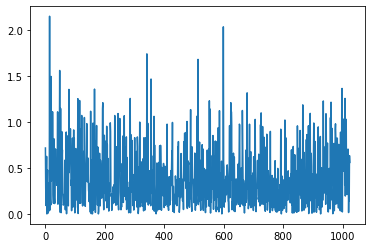

In [11]:
# We plot difference sorted by labels values
sort_index = np.argsort(labels)

plt.plot(abs(np.take_along_axis(np.array(labels), sort_index, 0) - predictions[sort_index]))

### Evaluating on test set



Download test set from "https://github.com/rdkit/rdkit/blob/master/Docs/Book/data/solubility.test.sdf"


Note: If there exists problem of reading the file solubility.test.sdf as
"RDKit ERROR: [09:28:36] ERROR: moving to the beginning of the next molecule
RDKit ERROR: [09:32:48] ERROR: Counts line too short: '' on line4"
so, go to the url, click "raw" and save this file by hand. The error will be gone away


In [12]:
!cd data && wget https://raw.githubusercontent.com/rdkit/rdkit/master/Docs/Book/data/solubility.test.sdf

--2022-04-06 14:05:55--  https://raw.githubusercontent.com/rdkit/rdkit/master/Docs/Book/data/solubility.test.sdf
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245735 (240K) [text/plain]
Saving to: ‘solubility.test.sdf.1’

solubility.test.sdf 100%[===================>] 239,98K   994KB/s    in 0,2s    

2022-04-06 14:05:56 (994 KB/s) - ‘solubility.test.sdf.1’ saved [245735/245735]




Read molecules from this file and store them in a list named **list_molecule_test**.


In [13]:
list_molecule_test = SDMolSupplier("data/solubility.test.sdf", removeHs=False)

print(f"we have {len(list_molecule_test)} test molecules.")

we have 257 test molecules.



Take a molecule from the **list_molecule_test** and then calculate its descriptions thank to the **calculate_descriptors(mol)** function that you've coded above.



In [14]:
df_test = pd.DataFrame([calculate_descriptors(mol) for mol in list_molecule_test])

test_labels = [float(mol.GetProp("SOL")) for mol in list_molecule_test]

na_list = df_test.isna().any(1)[df_test.isna().any(1) == True]
test_labels = np.delete(np.array(test_labels), na_list.index)
df_test.dropna(inplace=True)


Apply **minmaxscaler** to these descriptors. Note that **minmaxscaler**  is one that you've created for the training (do not fit again, only transform !!)



In [15]:
df_test = scaler.transform(df_test)


Use the model that you've trained to predict the aqueous solubility (logS) of the molecule. Compare to the real logS value of the molecule.



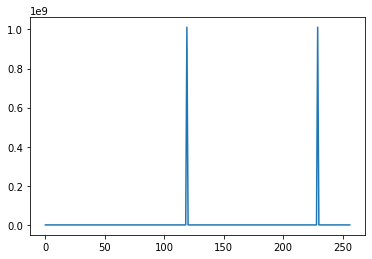

In [16]:
test_predictions = regressor.predict(df_test)
plt.plot(test_predictions)

we have two extreme outliers, we remove them from the prediction but we keep in mind that their is a problem about isolated outliers.

In [17]:
sort_values = test_predictions.argsort()
outliers_idx = sort_values[len(sort_values) - 2:]
test_predictions = np.delete(test_predictions, outliers_idx)
test_labels = np.delete(test_labels, outliers_idx)

Calculate the mean square root error of the model for this data. Compare it to the one of training set. Does it overfit ? 

In [18]:
test_mse = mean_squared_error(test_predictions, test_labels)

print(f"MSE of linear regression is: {round(test_mse, 3)}")

MSE of linear regression is: 0.398


The MSE value is pretty close to the train MS so we can't conclude that the model is overfitting. However, this test MSE is computed without extreme outliers so the conclusion needs to be in parenthesis.

### Other models (bonus)

Try to do hyperparameter search to find better linear models (check regularisation) 



Try to test with support vector machine

Try to test with gradient boosting regressor

Try to test with a small Feedforward network